In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertConfig, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import umap
from rdkit import Chem, RDLogger
import warnings
warnings.filterwarnings('ignore')
RDLogger.DisableLog('rdApp.*')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# === HELPER FUNCTIONS AND CLASSES ===

def load_lists_from_url(data):
    if data == 'bbbp':
        df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv')
        smiles, labels = df.smiles, df.p_np
    elif data == 'clintox':
        df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz', compression='gzip')
        smiles = df.smiles
        labels = df.drop(['smiles'], axis=1)
    elif data == 'hiv':
        df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/HIV.csv')
        smiles, labels = df.smiles, df.HIV_active
    elif data == 'sider':
        df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/sider.csv.gz', compression='gzip')
        smiles = df.smiles
        labels = df.drop(['smiles'], axis=1)
    elif data == 'esol':
        df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv')
        smiles = df.smiles
        labels = df['ESOL predicted log solubility in mols per litre']
    elif data == 'freesolv':
        df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/SAMPL.csv')
        smiles = df.smiles
        labels = df.calc
    elif data == 'lipophicility':
        df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv')
        smiles, labels = df.smiles, df['exp']
    elif data == 'tox21':
        df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip')
        df = df.dropna(axis=0, how='any').reset_index(drop=True)
        smiles = df.smiles
        labels = df.drop(['mol_id', 'smiles'], axis=1)
    elif data == 'bace':
        df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/bace.csv')
        smiles, labels = df.mol, df.Class
    elif data == 'qm8':
        df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm8.csv')
        df = df.dropna(axis=0, how='any').reset_index(drop=True)
        smiles = df.smiles
        labels = df.drop(['smiles', 'E2-PBE0.1', 'E1-PBE0.1', 'f1-PBE0.1', 'f2-PBE0.1'], axis=1)
    return smiles, labels

class SmilesEnumerator:
    """Generates randomized SMILES strings for data augmentation."""
    def randomize_smiles(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            return Chem.MolToSmiles(mol, doRandom=True, canonical=False) if mol else smiles
        except:
            return smiles

class MoleculeDataset(Dataset):
    def __init__(self, smiles_list, labels, tokenizer, max_len=512):
        self.smiles_list = smiles_list
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        smiles = self.smiles_list[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            smiles,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        if isinstance(label, pd.Series):
            label_values = label.values.astype(np.float32)
        else:
            label_values = np.array([label], dtype=np.float32)
        item['labels'] = torch.tensor(label_values, dtype=torch.float)
        return item

# Your model classes (assuming these exist from previous conversation)
def global_ap(x):
    return torch.mean(x.view(x.size(0), x.size(1), -1), dim=1)

class SimSonEncoder(nn.Module):
    def __init__(self, config: BertConfig, max_len: int, dropout: float = 0.1):
        super(SimSonEncoder, self).__init__()
        self.config = config
        self.max_len = max_len
        self.bert = BertModel(config, add_pooling_layer=False)
        self.linear = nn.Linear(config.hidden_size, max_len)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_ids, attention_mask=None):
        if attention_mask is None:
            attention_mask = input_ids.ne(self.config.pad_token_id)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.dropout(outputs.last_hidden_state)
        pooled = global_ap(hidden_states)
        return self.linear(pooled)

# === MAIN ANALYSIS FUNCTIONS ===

def prepare_dataset_with_augmentation(dataset_name, sample_size=1000):
    """
    Load dataset, create augmented SMILES, and prepare for embedding generation
    """
    print(f"Loading {dataset_name} dataset...")
    smiles, labels = load_lists_from_url(dataset_name)
    
    # Handle different label structures
    if dataset_name == 'bbbp':
        # Binary classification - convert to binary labels
        label_values = labels.values
        label_names = ['Non-permeable', 'Permeable']
    elif dataset_name == 'clintox':
        # Multi-task - use first task for visualization
        label_values = labels.iloc[:, 0].values  # Use first toxicity endpoint
        label_names = ['Non-toxic', 'Toxic']
    
    # Remove NaN labels and sample for visualization
    valid_mask = ~pd.isna(label_values)
    smiles_clean = smiles[valid_mask]
    labels_clean = label_values[valid_mask]
    
    # Sample for manageable visualization
    if len(smiles_clean) > sample_size:
        indices = np.random.choice(len(smiles_clean), sample_size, replace=False)
        smiles_clean = smiles_clean.iloc[indices]
        labels_clean = labels_clean[indices]
    
    # Create augmented SMILES
    enumerator = SmilesEnumerator()
    print("Generating augmented SMILES...")
    augmented_smiles = []
    
    for smiles_str in smiles_clean:
        aug_smiles = enumerator.randomize_smiles(smiles_str)
        augmented_smiles.append(aug_smiles)
    
    print(f"Dataset: {dataset_name}")
    print(f"Total molecules: {len(smiles_clean)}")
    print(f"Label distribution: {np.bincount(labels_clean.astype(int))}")
    
    return smiles_clean.tolist(), augmented_smiles, labels_clean, label_names

def generate_embeddings_for_classes(model, tokenizer, smiles_list, labels, batch_size=256, max_length=512):
    """Generate embeddings and organize by class labels"""
    model.eval()
    device = next(model.parameters()).device
    
    all_embeddings = []
    
    with torch.no_grad():
        for i in range(0, len(smiles_list), batch_size):
            batch_smiles = smiles_list[i:i+batch_size]
            
            # Tokenize batch
            tokens = tokenizer(batch_smiles, 
                             max_length=max_length, 
                             truncation=True, 
                             padding='max_length', 
                             return_tensors='pt')
            
            # Move to device
            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)
            
            # Generate embeddings
            batch_embeddings = model(input_ids, attention_mask)
            all_embeddings.append(batch_embeddings.cpu().numpy())
            
            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {i + len(batch_smiles)} / {len(smiles_list)} SMILES")
    
    embeddings = np.vstack(all_embeddings)
    
    # Organize by class
    class_embeddings = {}
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        mask = labels == label
        class_embeddings[label] = embeddings[mask]
    
    return embeddings, class_embeddings

def analyze_class_separation(class_embeddings, label_names):
    """Analyze how well different classes are separated in embedding space"""
    print("=== Class Separation Analysis ===")
    
    class_keys = list(class_embeddings.keys())
    
    if len(class_keys) == 2:
        # Binary classification analysis
        emb1 = class_embeddings[class_keys[0]]
        emb2 = class_embeddings[class_keys[1]]
        
        # Inter-class similarity (between different classes)
        inter_sim = cosine_similarity(emb1, emb2)
        mean_inter_sim = np.mean(inter_sim)
        
        # Intra-class similarity (within same class)
        intra_sim1 = cosine_similarity(emb1)
        intra_sim2 = cosine_similarity(emb2)
        
        # Remove diagonal for intra-class
        intra_sim1_off_diag = intra_sim1[np.triu_indices_from(intra_sim1, k=1)]
        intra_sim2_off_diag = intra_sim2[np.triu_indices_from(intra_sim2, k=1)]
        
        mean_intra_sim1 = np.mean(intra_sim1_off_diag)
        mean_intra_sim2 = np.mean(intra_sim2_off_diag)
        
        print(f"Class 0 ({label_names[0]}) size: {len(emb1)}")
        print(f"Class 1 ({label_names[1]}) size: {len(emb2)}")
        print(f"Mean inter-class similarity: {mean_inter_sim:.4f}")
        print(f"Mean intra-class similarity (Class 0): {mean_intra_sim1:.4f}")
        print(f"Mean intra-class similarity (Class 1): {mean_intra_sim2:.4f}")
        print(f"Separation ratio: {(mean_intra_sim1 + mean_intra_sim2)/(2 * mean_inter_sim):.4f}")
        
        return {
            'inter_class_sim': mean_inter_sim,
            'intra_class_sim': [mean_intra_sim1, mean_intra_sim2],
            'separation_ratio': (mean_intra_sim1 + mean_intra_sim2)/(2 * mean_inter_sim)
        }

def visualize_class_embeddings(embeddings, labels, label_names, dataset_name, sample_size=2000):
    """Create comprehensive visualizations of class-separated embeddings"""
    
    # Sample for visualization if needed
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        embeddings_viz = embeddings[indices]
        labels_viz = labels[indices]
        print(f"Sampling {sample_size} points for visualization")
    else:
        embeddings_viz = embeddings
        labels_viz = labels
    
    # Create color mapping
    unique_labels = np.unique(labels_viz)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{dataset_name.upper()} Dataset - Class Separation Visualization', fontsize=16, fontweight='bold')
    
    # PCA
    print("Computing PCA...")
    pca = PCA(n_components=2, random_state=42)
    pca_embeddings = pca.fit_transform(embeddings_viz)
    
    for label in unique_labels:
        mask = labels_viz == label
        axes[0, 0].scatter(pca_embeddings[mask, 0], pca_embeddings[mask, 1], 
                          c=[color_map[label]], label=f'{label_names[int(label)]} (n={np.sum(mask)})', 
                          alpha=0.7, s=30)
    
    axes[0, 0].set_title('PCA Visualization')
    axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # t-SNE
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_viz)//4))
    tsne_embeddings = tsne.fit_transform(embeddings_viz)
    
    for label in unique_labels:
        mask = labels_viz == label
        axes[0, 1].scatter(tsne_embeddings[mask, 0], tsne_embeddings[mask, 1], 
                          c=[color_map[label]], label=f'{label_names[int(label)]} (n={np.sum(mask)})', 
                          alpha=0.7, s=30)
    
    axes[0, 1].set_title('t-SNE Visualization')
    axes[0, 1].set_xlabel('t-SNE 1')
    axes[0, 1].set_ylabel('t-SNE 2')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # UMAP
    print("Computing UMAP...")
    umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=min(15, len(embeddings_viz)//4))
    umap_embeddings = umap_reducer.fit_transform(embeddings_viz)
    
    for label in unique_labels:
        mask = labels_viz == label
        axes[0, 2].scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1], 
                          c=[color_map[label]], label=f'{label_names[int(label)]} (n={np.sum(mask)})', 
                          alpha=0.7, s=30)
    
    axes[0, 2].set_title('UMAP Visualization')
    axes[0, 2].set_xlabel('UMAP 1')
    axes[0, 2].set_ylabel('UMAP 2')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Inter-class distance distribution
    if len(unique_labels) == 2:
        class_0_emb = embeddings_viz[labels_viz == unique_labels[0]]
        class_1_emb = embeddings_viz[labels_viz == unique_labels[1]]
        
        # Sample for distance calculation if too large
        if len(class_0_emb) > 500:
            class_0_sample = class_0_emb[np.random.choice(len(class_0_emb), 500, replace=False)]
        else:
            class_0_sample = class_0_emb
            
        if len(class_1_emb) > 500:
            class_1_sample = class_1_emb[np.random.choice(len(class_1_emb), 500, replace=False)]
        else:
            class_1_sample = class_1_emb
        
        inter_similarities = cosine_similarity(class_0_sample, class_1_sample).flatten()
        
        axes[1, 0].hist(inter_similarities, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 0].axvline(np.mean(inter_similarities), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(inter_similarities):.4f}')
        axes[1, 0].set_xlabel('Cosine Similarity')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title(f'Inter-Class Similarity Distribution')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Embedding norms by class
    for i, label in enumerate(unique_labels):
        mask = labels_viz == label
        norms = np.linalg.norm(embeddings_viz[mask], axis=1)
        axes[1, 1].hist(norms, bins=30, alpha=0.6, 
                       color=color_map[label], label=f'{label_names[int(label)]}')
    
    axes[1, 1].set_xlabel('L2 Norm')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Embedding Norm Distribution by Class')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Class statistics summary
    axes[1, 2].axis('off')
    stats_text = f"""
    {dataset_name.upper()} Dataset Statistics:
    
    • Total samples: {len(embeddings_viz):,}
    • Embedding dimension: {embeddings_viz.shape[1]}
    • Classes: {len(unique_labels)}
    """
    
    for i, label in enumerate(unique_labels):
        count = np.sum(labels_viz == label)
        percentage = 100 * count / len(labels_viz)
        stats_text += f"\n    - {label_names[int(label)]}: {count} ({percentage:.1f}%)"
    
    axes[1, 2].text(0.1, 0.9, stats_text, transform=axes[1, 2].transAxes, fontsize=12, 
                   verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    return pca_embeddings, tsne_embeddings, umap_embeddings

def clustering_analysis_for_classes(embeddings, labels, label_names, n_clusters=None):
    """Perform clustering analysis to evaluate class separation"""
    if n_clusters is None:
        n_clusters = len(np.unique(labels))
    
    print(f"\n=== Clustering Analysis (k={n_clusters}) ===")
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    # Calculate cluster purity
    cluster_purities = []
    for cluster_id in range(n_clusters):
        cluster_mask = cluster_labels == cluster_id
        cluster_true_labels = labels[cluster_mask]
        
        if len(cluster_true_labels) > 0:
            unique, counts = np.unique(cluster_true_labels, return_counts=True)
            purity = np.max(counts) / len(cluster_true_labels)
            cluster_purities.append(purity)
            print(f"Cluster {cluster_id}: {len(cluster_true_labels)} samples, purity: {purity:.3f}")
    
    avg_purity = np.mean(cluster_purities)
    print(f"Average cluster purity: {avg_purity:.4f}")
    
    
    return avg_purity

# === MAIN EXECUTION ===

def main_class_visualization():
    """Main function to run the complete class-based visualization analysis"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    tokenizer = AutoTokenizer.from_pretrained('DeepChem/ChemBERTa-77M-MTR')

    config = BertConfig(
        vocab_size=tokenizer.vocab_size,
        hidden_size=768,
        num_hidden_layers=4,
        num_attention_heads=12,
        intermediate_size=2048,
        max_position_embeddings=512
    )
    model = SimSonEncoder(config, max_len=512)  # Adjust max_len as needed
    model = torch.compile(model)
    
    model.to(device)
    model.eval()
    ds_name_to_model_path = {'bbbp': '/home/jovyan/simson_training_bolgov/moleculenet_eval/moleculenet_bbp_encoder.bin', 'clintox': '/home/jovyan/simson_training_bolgov/moleculenet_eval/moleculenet_clintox_encoder.bin'}
    
    
    # Analyze both datasets
    datasets = ['bbbp', 'clintox']
    
    for dataset_name in datasets:
        model.load_state_dict(torch.load(ds_name_to_model_path[dataset_name], map_location=device))
        print(f"\n{'='*50}")
        print(f"ANALYZING {dataset_name.upper()} DATASET")
        print(f"{'='*50}")
        
        # Prepare dataset
        smiles_list, augmented_smiles, labels, label_names = prepare_dataset_with_augmentation(
            dataset_name, sample_size=1000
        )
        
        # Generate embeddings for original SMILES
        print("Generating embeddings...")
        embeddings, class_embeddings = generate_embeddings_for_classes(
            model, tokenizer, smiles_list, labels
        )
        
        # Analyze class separation
        separation_stats = analyze_class_separation(class_embeddings, label_names)
        
        # Create visualizations
        pca_emb, tsne_emb, umap_emb = visualize_class_embeddings(
            embeddings, labels, label_names, dataset_name
        )
        
        # Clustering analysis
        clustering_analysis_for_classes(embeddings, labels, label_names)
        
        print(f"\nCompleted analysis for {dataset_name.upper()} dataset")


Using device: cuda

ANALYZING BBBP DATASET
Loading bbbp dataset...
Generating augmented SMILES...
Dataset: bbbp
Total molecules: 1000
Label distribution: [239 761]
Generating embeddings...
=== Class Separation Analysis ===
Class 0 (Non-permeable) size: 239
Class 1 (Permeable) size: 761
Mean inter-class similarity: -0.1155
Mean intra-class similarity (Class 0): 0.3215
Mean intra-class similarity (Class 1): 0.5806
Separation ratio: -3.9042
Computing PCA...
Computing t-SNE...
Computing UMAP...


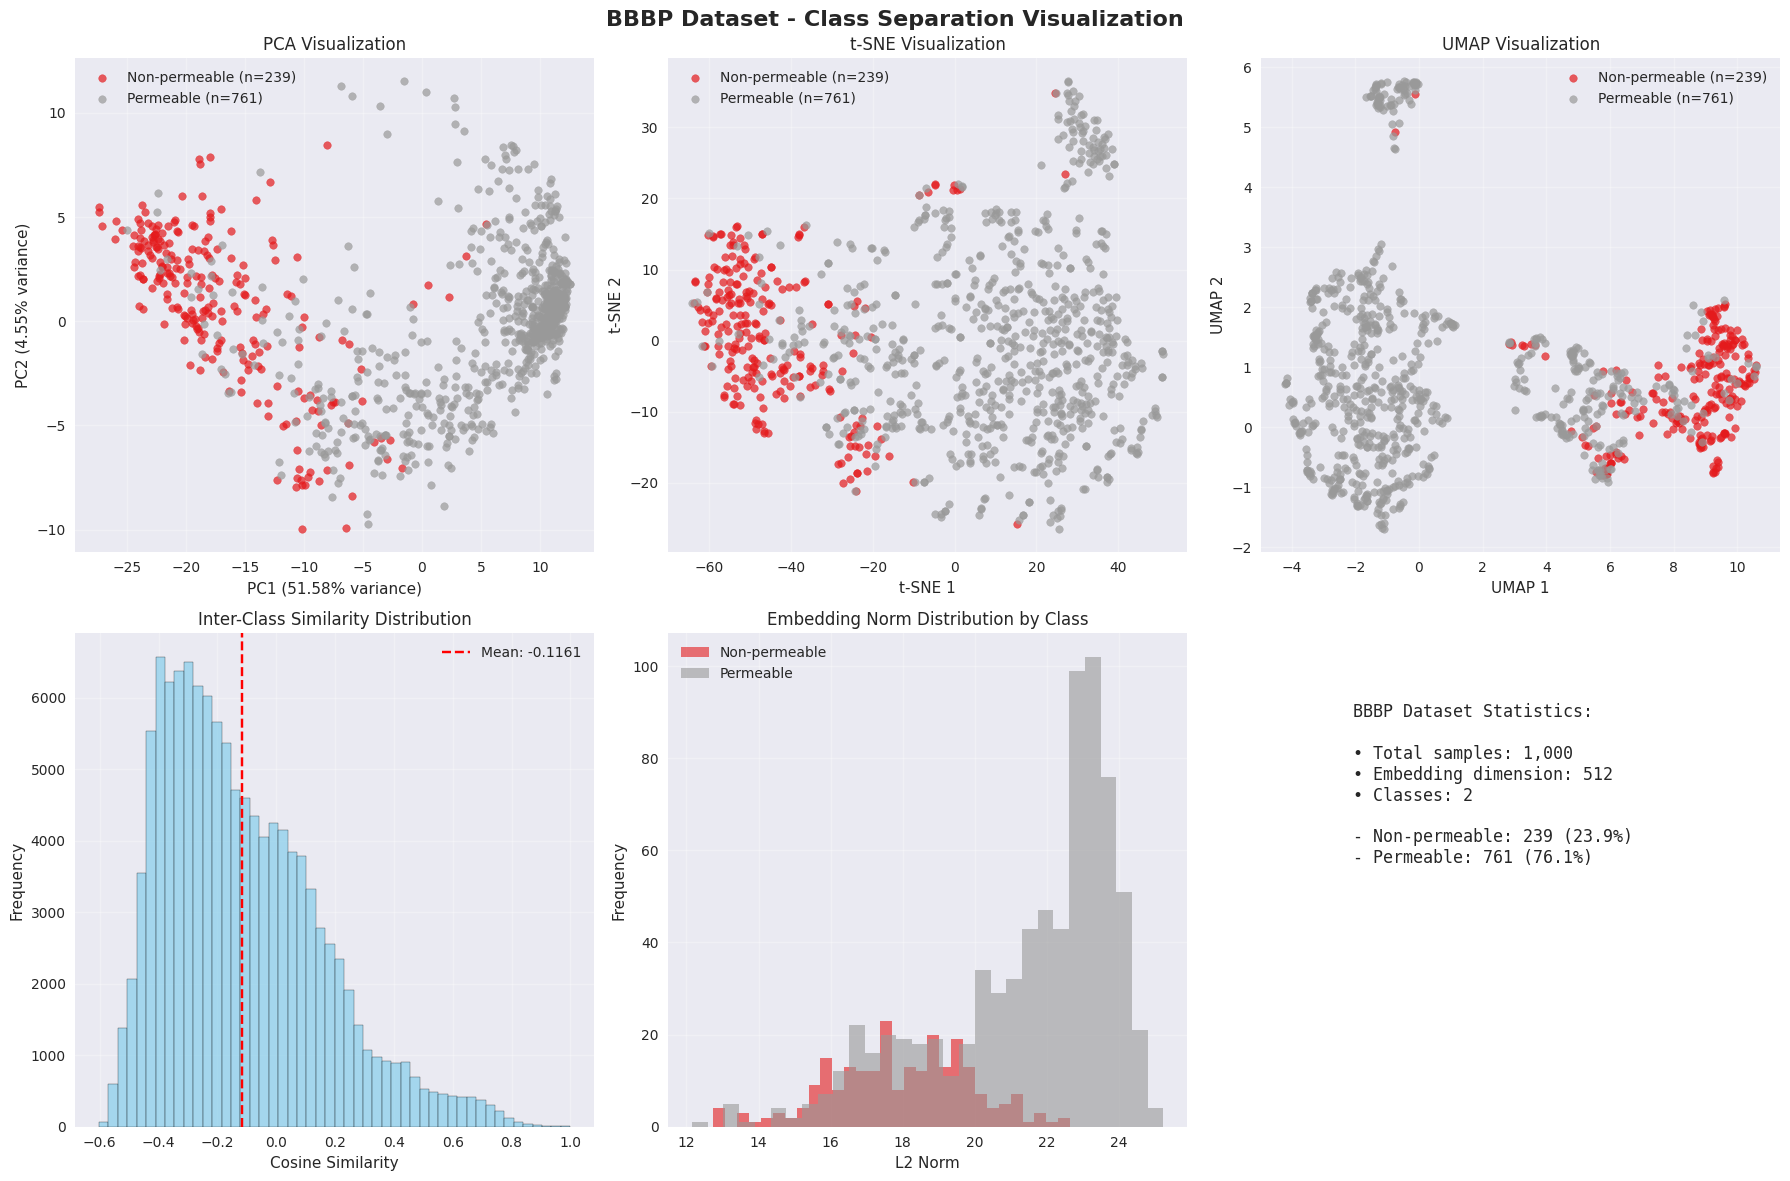


=== Clustering Analysis (k=2) ===
Cluster 0: 353 samples, purity: 0.654
Cluster 1: 647 samples, purity: 0.988
Average cluster purity: 0.8210

Completed analysis for BBBP dataset

ANALYZING CLINTOX DATASET
Loading clintox dataset...
Generating augmented SMILES...
Dataset: clintox
Total molecules: 1000
Label distribution: [ 64 936]
Generating embeddings...
=== Class Separation Analysis ===
Class 0 (Non-toxic) size: 64
Class 1 (Toxic) size: 936
Mean inter-class similarity: -0.0687
Mean intra-class similarity (Class 0): 0.7217
Mean intra-class similarity (Class 1): 0.9002
Separation ratio: -11.8095
Computing PCA...
Computing t-SNE...
Computing UMAP...


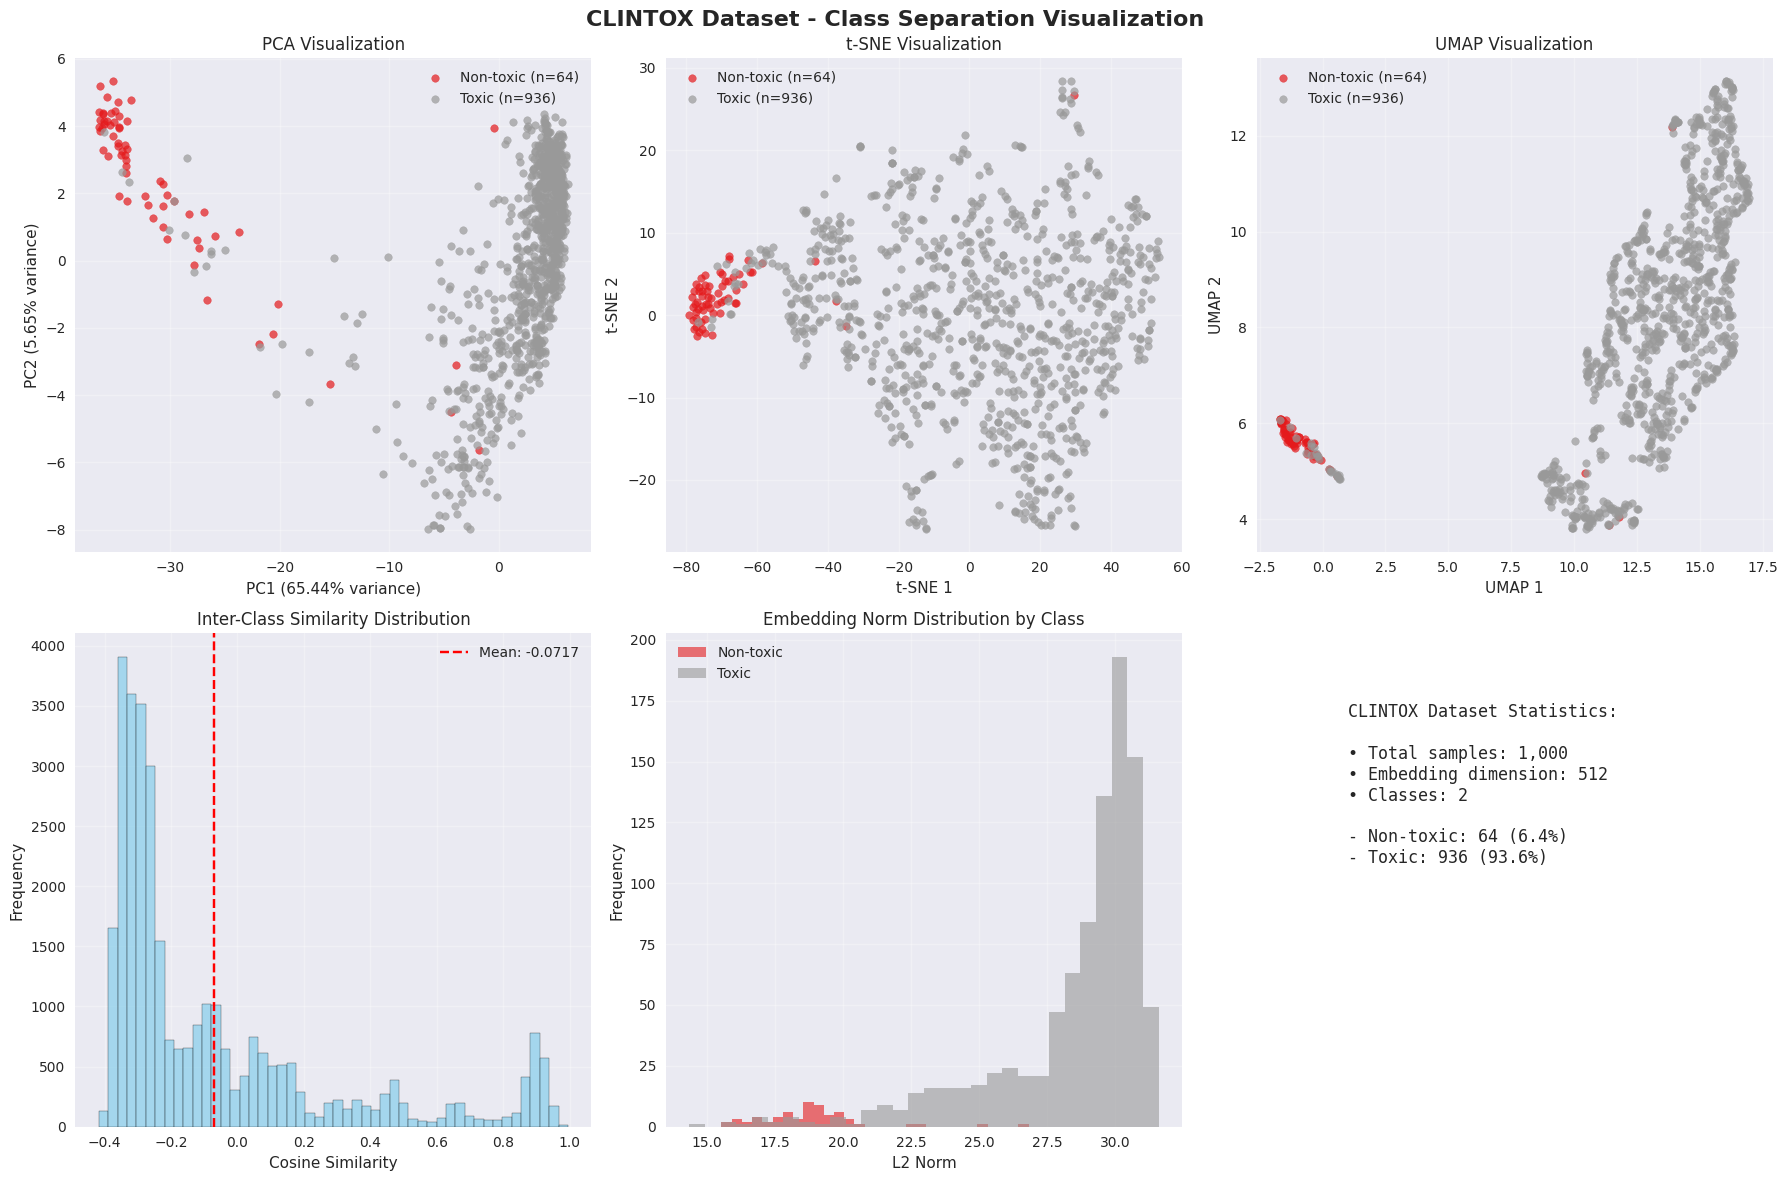


=== Clustering Analysis (k=2) ===
Cluster 0: 921 samples, purity: 0.996
Cluster 1: 79 samples, purity: 0.759
Average cluster purity: 0.8776

Completed analysis for CLINTOX dataset


In [31]:
if __name__ == "__main__":
    main_class_visualization()
